<a href="https://colab.research.google.com/github/rymuelle/CFB_pytorch_toy_minimizer/blob/master/bidirectional_team_rank_BNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install blitz-bayesian-pytorch

     |████████████████████████████████| 51kB 1.9MB/s 
     |████████████████████████████████| 4.0MB 7.8MB/s 
     |████████████████████████████████| 753.4MB 22kB/s 
     |████████████████████████████████| 7.1MB 14.4MB/s 
  Found existing installation: torch 1.5.1+cu101
    Uninstalling torch-1.5.1+cu101:
      Successfully uninstalled torch-1.5.1+cu101
  Found existing installation: torchvision 0.6.1+cu101
    Uninstalling torchvision-0.6.1+cu101:
      Successfully uninstalled torchvision-0.6.1+cu101
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [2]:
import numpy as np
import pandas as pd
import os
import math
import matplotlib.pyplot as plt
import time
import pylab as pl
from IPython import display
from blitz.modules import BayesianLinear, BayesianLSTM
from blitz.utils import variational_estimator
import torch
import torch.nn as nn

In [3]:
@variational_estimator
class BNN_LSTM(nn.Module):
  def __init__(self, input_size=1, hidden_layer_size=10, output_size=1,num_layers=1,use_softmax=False, device=torch.device("cpu")):
    super().__init__()
    self.hidden_layer_size=hidden_layer_size
    self.num_layers=num_layers
    self.lstm=nn.LSTM(input_size,hidden_layer_size,num_layers)

    self.blinear=BayesianLinear(hidden_layer_size,output_size)


    self.hidden_cell=(torch.zeros(num_layers,1,self.hidden_layer_size),
                      torch.zeros(num_layers,1,hidden_layer_size))
    self.use_softmax=use_softmax
    if use_softmax: self.softmax=nn.Softmax()

    self.device = device

    self.loss_array = []
  def last_timestep(self, unpacked, lengths):
    # Index of the last output for each sequence.
    idx = (lengths - 1).view(-1, 1).expand(unpacked.size(0),
                                           unpacked.size(2)).unsqueeze(1)
    return unpacked.gather(1, idx).squeeze()
  def forward(self, input_seq,lengths):
    lstm_out, self.hidden_cell = self.lstm(input_seq,None)
    out_unpacked, _ = nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)
    last_outputs = self.last_timestep(out_unpacked, lengths)
    predictions = self.blinear(last_outputs)
    return predictions
  def test(self, X, y,lengths, loss_function, samples = 100):
    with torch.no_grad():
      packed = nn.utils.rnn.pack_padded_sequence(X,lengths,batch_first=True)
      preds = torch.stack([self(packed,lengths) for i in range(samples)])
      means = preds.mean(axis=0)
      stds = preds.std(axis=0)
      single_loss=loss_function(means,y)
    return single_loss, means, stds
  def train(self, X, y, lengths, optimizer, loss_function, epochs=10, draw_fig=False,reg_lr=1e-5,sample_nbr=4):
    for i in range(epochs):
      optimizer.zero_grad()
      packed = nn.utils.rnn.pack_padded_sequence(X,lengths,batch_first=True)
      reg_loss = 0
      train_loss = 0
      for _ in range(sample_nbr):
          y_pred = self(packed,lengths)
          train_loss += loss_function(y_pred, y) 
          reg_loss += self.nn_kl_divergence()*reg_lr
      reg_loss = reg_loss/sample_nbr
      train_loss = train_loss/sample_nbr
      loss = train_loss + reg_loss
      loss.backward()
      optimizer.step()
      self.loss_array.append(train_loss.item())
    if draw_fig:
      pl.clf()
      pl.plot(self.loss_array)
      display.clear_output(wait=True)
      display.display(pl.gcf())
      print(f'epoch:  loss: {train_loss.item():10.8f}')
    return self.loss_array
  def evaluate_regression(self, X, y, lengths, samples = 100, std_multiplier = 2):
    packed = nn.utils.rnn.pack_padded_sequence(X,lengths,batch_first=True)
    preds = [self(packed,lengths) for i in range(samples)]
    preds = torch.stack(preds)
    means = preds.mean(axis=0)
    stds = preds.std(axis=0)
    ci_upper = means + (std_multiplier * stds)
    ci_lower = means - (std_multiplier * stds)
    results = (torch.stack([ci_lower,means, ci_upper],dim=2))
    ic_acc = (ci_lower <= y) * (ci_upper >= y)
    ic_acc = ic_acc.float().mean()
    return ic_acc, (ci_upper >= y).float().mean(), (ci_lower <= y).float().mean(), results

In [4]:
dtype = torch.float
device = torch.device("cpu")
device = torch.device("cuda:0")

In [5]:
n_samples = 500
length_sample = 4
label_std = 14
seq_std = 14
label_offset = 0
label_std = label_std/40
seq_std = seq_std/40
label_offset =.5
def create_sample(n_samples,length_sample,label_std,seq_std, label_offset):
    labels = np.random.normal(label_offset, label_std, size=(n_samples, 1))
    
    std_array = np.abs(np.random.normal(seq_std, seq_std/2, size=(n_samples, length_sample)))
    for index, label in enumerate(labels):
      std_array[index]*=abs(label)*1
    #std_array.fill(.1)
    seqs = np.random.normal(0, std_array, size=(n_samples, length_sample))
    seqs = seqs+labels
    seqs = [torch.FloatTensor((seq).tolist()).to(device) for seq in seqs]
    std_array = [torch.FloatTensor((std).tolist()).to(device) for std in std_array]
    labels = [torch.FloatTensor((lab).tolist()).to(device) for lab in labels]
    seq_std_stacks = [(torch.stack([seq,std_array[index]],dim=1)) for index, seq in enumerate(seqs)]
    seq_std_stacks = torch.stack(seq_std_stacks).to(device)
    labels = torch.stack(labels).to(device)
    lengths = torch.tensor([len(seq_std_stack) for seq_std_stack in seq_std_stacks],device=device,dtype=torch.int64)
    return seq_std_stacks,labels,lengths

In [6]:
seq_std_stacks,labels,lengths = create_sample(n_samples,length_sample,label_std,seq_std,label_offset)

In [7]:
def weighted_average_loss(seq_std_stacks,labels):
    array = []
    array_weighted = []
    for index, seq_std_stack in enumerate(seq_std_stacks):
        label = labels[index]
        seq,std = torch.split(seq_std_stack,1, dim=1)
        average = torch.mean(seq).item()
        weight = 1.0/(std**2)
        weighted_average = np.average(seq.tolist(), weights = weight.tolist())
        array.append((average-label.item())**2)
        array_weighted.append((weighted_average-label.item())**2)
    loss_average = np.mean(array)
    loss_average_weighted = np.mean(array_weighted)
    return loss_average, loss_average_weighted

In [8]:
loss_average, loss_average_weighted = weighted_average_loss(seq_std_stacks,labels)
print("unweighted",  loss_average)
print("weighted", loss_average_weighted)

unweighted 0.013759634265093194
weighted 0.006628138940029337


In [9]:
model=BNN_LSTM(input_size=2,hidden_layer_size=16,output_size=1,num_layers=1).to(device)
#loss_function=nn.CrossEntropyLoss()
#optimizer=torch.optim.Adam(model.parameters(), lr=1e-4)
loss_function=nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(), lr=1e-2)
print(model)

BNN_LSTM(
  (lstm): LSTM(2, 16)
  (blinear): BayesianLinear(
    (weight_sampler): TrainableRandomDistribution()
    (bias_sampler): TrainableRandomDistribution()
    (weight_prior_dist): PriorWeightDistribution()
    (bias_prior_dist): PriorWeightDistribution()
  )
)


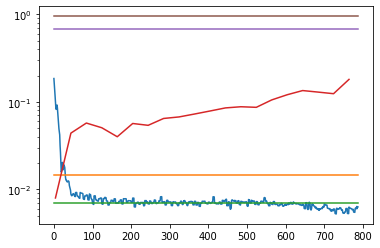

In [ ]:
seq_std_stacks,labels,lengths = create_sample(n_samples*3,length_sample,label_std,seq_std,label_offset)
loss_average, loss_average_weighted = weighted_average_loss(seq_std_stacks,labels)
optimizer=torch.optim.Adam(model.parameters(), lr=1e-2)
draw_fig=True
acc_array=[]
epoch_array=[]
for i in range(600):
    seq_std_stacks,labels,lengths = create_sample(n_samples*3,length_sample,label_std,seq_std,label_offset)
    loss_array = model.train(seq_std_stacks,labels,lengths,optimizer,loss_function,epochs=4,draw_fig=False,reg_lr=1e-5,sample_nbr=4)
    if draw_fig:
        pl.clf()
        pl.yscale('log')
        pl.plot(loss_array)
        pl.plot([0,len(loss_array)],[loss_average,loss_average])
        pl.plot([0,len(loss_array)],[loss_average_weighted,loss_average_weighted])
        pl.plot(epoch_array,acc_array)
        pl.plot([0,len(loss_array)],[.68,.68])
        pl.plot([0,len(loss_array)],[.95,.95])
        #print(f'epoch: {i:3}  loss: {loss_array[-1]:10.8f}')
        display.clear_output(wait=True)
        display.display(pl.gcf())
        if i%10==0:
            ic_acc, under_ci_upper, over_ci_lower,_ = model.evaluate_regression(seq_std_stacks,labels,lengths,samples=25,std_multiplier=3)
            acc_array.append(ic_acc)
            epoch_array.append(len(loss_array))
        #print("CI acc: {:.2f}, CI upper acc: {:.2f}, CI lower acc: {:.2f}".format(ic_acc, under_ci_upper, over_ci_lower))
    if i ==450: optimizer=torch.optim.Adam(model.parameters(), lr=1e-3)
    #if i ==400: optimizer=torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
print(model)

BNN_LSTM(
  (lstm): LSTM(2, 16)
  (blinear): BayesianLinear(
    (weight_sampler): TrainableRandomDistribution()
    (bias_sampler): TrainableRandomDistribution()
    (weight_prior_dist): PriorWeightDistribution()
    (bias_prior_dist): PriorWeightDistribution()
  )
)


tensor(0.7012, device='cuda:0') tensor(0.8208, device='cuda:0') tensor(0.8804, device='cuda:0') tensor(2.4024, device='cuda:0')


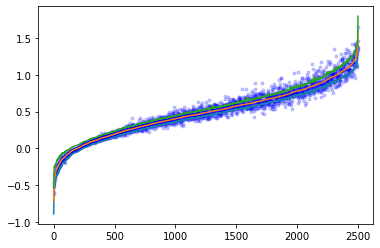

In [ ]:
seq_std_stacks,labels,lengths = create_sample(5*n_samples,length_sample,label_std,seq_std,label_offset)
ic_acc, under_ci_upper, over_ci_lower,results = model.evaluate_regression(X=seq_std_stacks,y=labels,lengths=lengths,std_multiplier=7)
print(ic_acc, under_ci_upper, over_ci_lower,ic_acc+under_ci_upper+over_ci_lower)
act_arr=[]
pred_array=[]
pred_array_up=[]
pred_array_down=[]
for index, result in enumerate(results):
    act_arr.append(labels[index].item())
    pred_array.append(result[0][1].item())
    pred_array_up.append(result[0][2].item())
    pred_array_down.append(result[0][0].item())
    
pred_array, act_arr,pred_array_up,pred_array_down = zip(*sorted(zip(pred_array, act_arr,pred_array_up,pred_array_down)))
pl.plot(act_arr,'b.',label='act_arr', alpha=.2)
pl.plot(pred_array_down,label='pred_array_down')
pl.plot(pred_array,label='pred_array')
pl.plot(pred_array_up,label='pred_array_up')

In [ ]:
seq_std_stacks,labels,lengths = create_sample(n_samples,length_sample,label_std,seq_std,label_offset)
loss, preds, stds=model.test(seq_std_stacks,labels,lengths,loss_function,samples = 200)
loss_2=[]
chi_2=[]
for index, pred in enumerate(preds):
    loss_2.append((pred.item()-labels[index].item())**2)
    chi_2.append((pred.item()-labels[index].item())**2/stds[index].item()**2)
loss_average, loss_average_weighted = weighted_average_loss(seq_std_stacks,labels)
print("unweighted average loss {}".format(loss_average))
print("weigthed average loss {}".format(loss_average_weighted))
print("manual LSTM loss {} chi2: {}".format(np.mean(loss_2),np.mean(chi_2)))
print("torch loss {}".format(loss))

unweighted average loss 0.013805671438912558
weigthed average loss 0.006968230239582695
manual LSTM loss 0.0038234160179055825 chi2: 67.63224176318752
torch loss 0.003823415841907263


In [ ]:
n_samples = 500
length_sample = 8
labels = np.random.rand(n_samples, 1)
seqs = (np.random.rand(n_samples, length_sample)-.5)/2+labels
in_out_seq = [(torch.FloatTensor((seqs[index]).tolist()).to(device),
               torch.FloatTensor(label.tolist()).to(device))
              for index, label in enumerate(labels)]

In [ ]:
mean_std=torch.FloatTensor([[1,.5]])
